In [82]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [83]:
# Load the dataset
df = pd.read_csv('ocr_dataset.csv', header=None)

# Group into 8-row chunks (7 binary rows + 1 ASCII row)
chunks = [df.iloc[i:i+8].reset_index(drop=True) for i in range(0, len(df), 8)]

X = []
y = []

for chunk in chunks:
    matrix = chunk.iloc[:7].values.astype(int)
    ascii_code = int(chunk.iloc[7, 0])
    
    # Sum of columns (axis=0) and rows (axis=1)
    col_sums = matrix.sum(axis=0)  # 5 values
    row_sums = matrix.sum(axis=1)  # 7 values
    
    features = np.concatenate([col_sums, row_sums])  # 12 total
    X.append(features)
    y.append(ascii_code)

X = np.array(X)
y = np.array(y)

# Convert labels to 0–35 class indices
unique_labels = sorted(set(y))
label_map = {val: i for i, val in enumerate(unique_labels)}
y_classes = np.array([label_map[val] for val in y])


In [92]:
# One-hot encode the output classes
y_onehot = to_categorical(y_classes, num_classes=36)

model = Sequential([
    Dense(24, input_dim=12, activation='relu'),
    Dense(18, activation='relu'),
    Dense(36, activation='softmax')  # 36 classes (A-Z, 0–9)
])

adam = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, verbose=1)
]

history = model.fit(
    X, y_onehot,
    epochs=400,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 3.8269 - learning_rate: 0.0010
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 3.8006 - learning_rate: 0.0010
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 3.7686 - learning_rate: 0.0010
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 3.7416 - learning_rate: 0.0010
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 3.7670 - learning_rate: 0.0010
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0289 - loss: 3.7059 - learning_rate: 0.0010
Epoch 7/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0289 - loss: 3.6990 - learning_rate: 0.0010
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0289 - loss: 3.6639 - learning_rate: 0.0010
Epoch 9/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0289 - loss: 3.6561 - learning_rate: 0.0010
Epoch 10

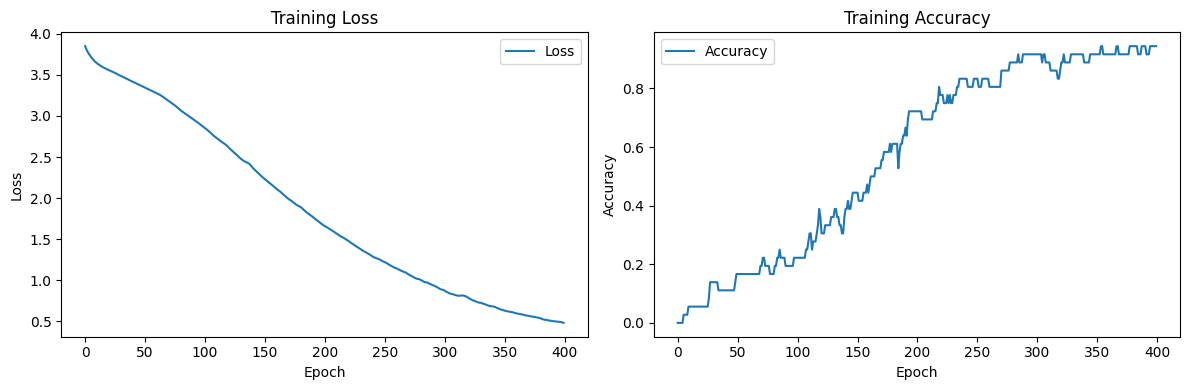

In [93]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [94]:
# Save the model
model.save('ocr_model.keras')
print("Model saved as ocr_model.keras")

Model saved as ocr_model.keras


In [95]:
def draw_input_to_features(draw_lines):
    matrix = np.array([[int(char) for char in line] for line in draw_lines])
    col_sums = matrix.sum(axis=0)
    row_sums = matrix.sum(axis=1)
    return np.concatenate([col_sums, row_sums]).reshape(1, -1)

# Example user input
drawn_character = [
    "01110",
    "10001",
    "10001",
    "10001",
    "10001",
    "10001",
    "01110"
]

features = draw_input_to_features(drawn_character)
prediction = model.predict(features, verbose=0)
predicted_class_index = np.argmax(prediction)
predicted_ascii = unique_labels[predicted_class_index]
print("Predicted ASCII:", predicted_ascii, "Char:", chr(predicted_ascii))


Predicted ASCII: 79 Char: O
